# 1. 부동산 자체에 대한 정보

In [54]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from sklearn.preprocessing import RobustScaler

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # '맑은 고딕' 폰트 설정
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
# 문자열 길이 제한을 없앰
pd.set_option('display.max_colwidth', None)

In [3]:
# CSV 파일 목록 불러오기
folder_path = './property'
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# 컬럼 구조별로 대응되는 파일 목록을 저장할 딕셔너리
column_groups = {}

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    
    try:
        with open(file_path, 'r', encoding='euc-kr') as f:
            lines = f.readlines()

        header_found = False
        columns = []
        data_start_index = None

        # 파일의 각 행을 처리하여 헤더 찾기
        for i, line in enumerate(lines):
            row_data = line.strip().split(',')
            if len(row_data) > 10 and not header_found:
                columns = row_data  # 컬럼 추출
                header_found = True
                data_start_index = i + 1
                break

        # 헤더가 발견된 이후 처리
        if header_found:
            if len(lines) - 1 != i:
                cleaned_columns = [col.replace('"', '') for col in columns]
                col_tuple = tuple(cleaned_columns)
                
                # 같은 컬럼 구조를 가진 파일끼리 그룹화
                if col_tuple not in column_groups:
                    column_groups[col_tuple] = []
                column_groups[col_tuple].append((file, data_start_index))

    except Exception as e:
        print(f"Error processing file {file}: {e}")
        continue

# 결과 출력 (같은 컬럼을 가진 파일들끼리 그룹화)
for col_set, files in column_groups.items():
    print(f"Columns: {col_set}")
    for file_info in files:
        print(f"Corresponding CSV file: {file_info[0]}, Data Start Index: {file_info[1]}")
    print("\n")

Columns: ('NO', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)', '동', '층', '매수자', '매도자', '건축년도', '도로명', '해제사유발생일', '거래유형', '중개사소재지', '등기일자')
Corresponding CSV file: 202309.csv, Data Start Index: 16
Corresponding CSV file: 202310.csv, Data Start Index: 16
Corresponding CSV file: 202311.csv, Data Start Index: 16
Corresponding CSV file: 202312.csv, Data Start Index: 16
Corresponding CSV file: 202401.csv, Data Start Index: 16
Corresponding CSV file: 202402.csv, Data Start Index: 16
Corresponding CSV file: 202403.csv, Data Start Index: 16
Corresponding CSV file: 202404.csv, Data Start Index: 16
Corresponding CSV file: 202405.csv, Data Start Index: 16
Corresponding CSV file: 202406.csv, Data Start Index: 16
Corresponding CSV file: 202407.csv, Data Start Index: 16
Corresponding CSV file: 202408.csv, Data Start Index: 16




In [4]:
# 서로 다른 종류의 columns 통합기기
dfs = {}

for col_set, files in column_groups.items():    
    data_list = []
    
    for file, data_start_index in files:
        file_path = os.path.join(folder_path, file)
        try:
            df = pd.read_csv(file_path, encoding='euc-kr', skiprows=data_start_index, thousands=',', names=col_set)
            data_list.append(df)
        
        except Exception as e:
            continue

    if data_list:
        combined_df = pd.concat(data_list, ignore_index=True)
    else:
        combined_df = pd.DataFrame(columns=col_set)

    dfs[col_set] = combined_df

In [5]:
for col_set, df in dfs.items():
    print(col_set)
    display(df.head())

('NO', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)', '동', '층', '매수자', '매도자', '건축년도', '도로명', '해제사유발생일', '거래유형', '중개사소재지', '등기일자')


,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,대구광역시 남구 대명동,1733-3,1733,3,경일맨션,68.3000,202309,30,10000,-,3,-,-,1977,현충로 190,-,중개거래,대구 남구,23.10.25
1,2,인천광역시 중구 중산동,1887-1,1887,1,영종하늘도시한라비발디,101.5405,202309,30,36200,924,2,-,-,2012,하늘별빛로 86,-,직거래,-,23.10.30
2,3,인천광역시 미추홀구 주안동,1618,1618,0,월드스테이트(201~205),59.9960,202309,30,34900,202,19,-,-,2008,경원대로864번길 114,-,중개거래,인천 남동구 인천 미추홀구,23.11.06
3,4,서울특별시 양천구 신월동,987-1,987,1,신월시영,50.6700,202309,30,51000,8,5,-,-,1988,신월로 99,-,직거래,-,23.11.14
4,5,인천광역시 부평구 부평동,222-2,222,2,스위트홈,38.4700,202309,30,19000,스위트홈,9,-,-,2014,시장로 67,-,중개거래,인천 부평구,23.11.03


In [6]:
# 각 DataFrame을 합칠 준비
dfs_to_concat = []

# 모든 DataFrame을 리스트에 추가 (합칠 준비)
for col_set, df in dfs.items():
    dfs_to_concat.append(df)

# DataFrame을 합칠 때 column의 합집합을 유지하도록 pd.concat 사용
df = pd.concat(dfs_to_concat, axis=0, ignore_index=True, sort=False)
df.head()

,NO,시군구,번지,본번,부번,단지명,전용면적(㎡),계약년월,계약일,거래금액(만원),동,층,매수자,매도자,건축년도,도로명,해제사유발생일,거래유형,중개사소재지,등기일자
0,1,대구광역시 남구 대명동,1733-3,1733,3,경일맨션,68.3000,202309,30,10000,-,3,-,-,1977,현충로 190,-,중개거래,대구 남구,23.10.25
1,2,인천광역시 중구 중산동,1887-1,1887,1,영종하늘도시한라비발디,101.5405,202309,30,36200,924,2,-,-,2012,하늘별빛로 86,-,직거래,-,23.10.30
2,3,인천광역시 미추홀구 주안동,1618,1618,0,월드스테이트(201~205),59.9960,202309,30,34900,202,19,-,-,2008,경원대로864번길 114,-,중개거래,인천 남동구 인천 미추홀구,23.11.06
3,4,서울특별시 양천구 신월동,987-1,987,1,신월시영,50.6700,202309,30,51000,8,5,-,-,1988,신월로 99,-,직거래,-,23.11.14
4,5,인천광역시 부평구 부평동,222-2,222,2,스위트홈,38.4700,202309,30,19000,스위트홈,9,-,-,2014,시장로 67,-,중개거래,인천 부평구,23.11.03


# 2. 부동산 가격 df의 column 다듬기

In [7]:
df.columns

Index(['NO', '시군구', '번지', '본번', '부번', '단지명', '전용면적(㎡)', '계약년월', '계약일',
       '거래금액(만원)', '동', '층', '매수자', '매도자', '건축년도', '도로명', '해제사유발생일', '거래유형',
       '중개사소재지', '등기일자'],
      dtype='object')

In [8]:
# '시군구' 열을 빈칸 기준으로 모두 나눈 후, 첫 번째와 두 번째 값을 가져오기
split_columns = df['시군구'].str.split(' ', expand=True)

df['도/특별시/광역시'] = split_columns[0]
df['시/군/구'] = split_columns[1]
df.drop(columns=['시군구'], inplace=True)

In [9]:
df = df[['전용면적(㎡)', '계약년월', '계약일', '거래금액(만원)', '층', '건축년도', '도/특별시/광역시', '시/군/구']]

In [10]:
# DataFrame이 슬라이스된 경우 복사
df = df.copy()

# 계약날짜 생성
df['계약날짜'] = pd.to_datetime(df['계약년월'].astype(str) + df['계약일'].astype(str), format='%Y%m%d')

# 계약년월과 계약일 열 삭제
df.drop(columns=['계약년월', '계약일'], inplace=True)

In [11]:
df = df.drop_duplicates()
df.head()

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜
0,68.3000,10000,3,1977,대구광역시,남구,2023-09-30
1,101.5405,36200,2,2012,인천광역시,중구,2023-09-30
2,59.9960,34900,19,2008,인천광역시,미추홀구,2023-09-30
3,50.6700,51000,5,1988,서울특별시,양천구,2023-09-30
4,38.4700,19000,9,2014,인천광역시,부평구,2023-09-30


# 3. 금리 정보 추가

In [12]:
rate_df = pd.read_csv("rate.csv")
rate_df['날짜'] = pd.to_datetime(rate_df['변경일자'].astype(str) + ' ' + rate_df['Unnamed: 1'], format='%Y %m월 %d일')
rate_df = rate_df[['날짜', '기준금리']]
rate_df.head()

,날짜,기준금리
0,2023-01-13,3.50
1,2022-11-24,3.25
2,2022-10-12,3.00
3,2022-08-25,2.50
4,2022-07-13,2.25


In [13]:
# 날짜 열을 datetime 형식으로 변환
df['계약날짜'] = pd.to_datetime(df['계약날짜'])
rate_df['날짜'] = pd.to_datetime(rate_df['날짜'])

# 계약날짜와 기준금리를 병합 (가장 가까운 과거 기준금리를 찾음)
df = pd.merge_asof(df.sort_values('계약날짜'),
                   rate_df.sort_values('날짜'),
                   left_on='계약날짜',
                   right_on='날짜',
                   direction='backward')

# '날짜' 열이 중복되므로 필요 없다면 제거
df = df.drop(columns=['날짜'])

In [14]:
df.head(10)

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜,기준금리
0,59.9700,72000,6,2005,서울특별시,성북구,2023-09-01,3.5
1,84.7400,33000,12,1999,경기도,김포시,2023-09-01,3.5
2,59.7600,13000,3,2003,경기도,안성시,2023-09-01,3.5
3,84.8600,16800,12,1991,충청북도,청주시,2023-09-01,3.5
4,84.9755,18300,13,2011,경상남도,사천시,2023-09-01,3.5
5,77.1700,27800,13,2018,경기도,안성시,2023-09-01,3.5
6,59.9612,30000,8,2017,경상남도,김해시,2023-09-01,3.5
7,39.9000,3100,1,1995,충청남도,당진시,2023-09-01,3.5
8,39.5100,7100,2,2000,충청남도,금산군,2023-09-01,3.5
9,74.9690,17950,18,2018,충청북도,보은군,2023-09-01,3.5


# 4. 환율 정보 추가

In [15]:
# Excel 파일 읽기
exchange_df = pd.read_excel("exchange.xlsx")

# 6번째 행부터 첫 두 열을 선택
exchange_df = exchange_df.iloc[6:, :2]

# 인덱스 재설정
exchange_df.reset_index(drop=True, inplace=True)

# 첫 번째와 두 번째 열의 이름을 "날짜"와 "환율"로 변경
exchange_df.columns = ["날짜", "환율"]
exchange_df['날짜'] = pd.to_datetime(exchange_df['날짜'], errors='coerce')
exchange_df.head()

,날짜,환율
0,1990-03-02,693
1,1990-03-05,695.1
2,1990-03-06,696.4
3,1990-03-07,697.6
4,1990-03-08,698.1


In [16]:
# 계약날짜 기준으로 가장 가까운 과거의 날짜에 해당하는 환율을 찾기 위해 merge_asof 사용
df = pd.merge_asof(df.sort_values('계약날짜'), exchange_df.sort_values('날짜'),
                   left_on='계약날짜', right_on='날짜', direction='backward')
df.drop(columns=["날짜"], inplace=True)
df.head()

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜,기준금리,환율
0,59.9700,72000,6,2005,서울특별시,성북구,2023-09-01,3.5,1318.8
1,49.6800,28000,10,1989,경기도,수원시,2023-09-01,3.5,1318.8
2,84.9800,82500,18,2015,경기도,하남시,2023-09-01,3.5,1318.8
3,75.9000,21500,10,1986,대전광역시,서구,2023-09-01,3.5,1318.8
4,84.9849,33800,9,2006,대전광역시,유성구,2023-09-01,3.5,1318.8


# 5. 인구 수 추가 전 행정구역 명칭 정리

In [17]:
df['도/특별시/광역시'].value_counts()

도/특별시/광역시
경기도        115855
서울특별시       49652
경상남도        30750
인천광역시       27831
부산광역시       25975
충청남도        23286
경상북도        22863
대구광역시       22598
전북특별자치도     17961
충청북도        17906
강원특별자치도     16522
광주광역시       14389
전라남도        14084
대전광역시       12955
울산광역시       12028
세종특별자치시      3926
제주특별자치도      2176
Name: count, dtype: int64

In [18]:
df['도/특별시/광역시'] = df['도/특별시/광역시'].replace("전북특별자치도", "전라북도")

In [19]:
# "시/군/구" 열의 각 값의 길이를 계산
lengths = df['시/군/구'].str.len()

# 각 길이별로 값의 개수 계산
length_counts = lengths.value_counts().sort_index()

# 결과 출력
print("길이별 '시/군/구' 값의 개수:")
print(length_counts)

길이별 '시/군/구' 값의 개수:
시/군/구
0      3926
2     53118
3    347078
4     26635
Name: count, dtype: int64


In [20]:
# "시/군/구" 열에서 길이가 0인 행들 필터링
filtered_df = df[df['시/군/구'].str.len() == 0]

# 필터링된 행들에서 "도/특별시/광역시" 열의 고유 값 확인
unique_values = filtered_df['도/특별시/광역시'].unique()

# 결과 출력
print("시/군/구의 길이가 0인 행들의 '도/특별시/광역시' 값들:", unique_values)

시/군/구의 길이가 0인 행들의 '도/특별시/광역시' 값들: ['세종특별자치시']


In [21]:
filtered_df = df[df['시/군/구'].str.len() == 4]
filtered_df['시/군/구'].value_counts()

시/군/구
남양주시    5693
의정부시    4192
부산진구    3192
해운대구    2956
미추홀구    2587
영등포구    2515
동대문구    2059
서대문구    1879
동두천시     895
서귀포시     667
Name: count, dtype: int64

In [22]:
df['시/군/구'] = df['시/군/구'].replace('부산진구', '진구')

# 6. 인구 수 추가

In [23]:
pop_df = pd.read_excel("population.xlsx", usecols=[0, 1])
pop_df.columns = ['지역', '인구수']
pop_df['지역'] = pop_df['지역'].str.replace('\u3000', '').str.strip()
pop_df.head()

C:\Users\PhamPham\Miniconda3\envs\my_venv\Lib\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,지역,인구수
0,행정구역별(읍면동),총인구 (명)
1,전국,51774521
2,읍부,5131418
3,면부,4536053
4,동부,42107050


In [24]:
population_dict = {}
current_key = None
region_keywords = ['특별시', '광역시', '특별자치시', '도']

for index, row in pop_df.iterrows():
    region = row[0]
    population = row[1]

    # 도/특별시/광역시/특별자치시가 이름에 포함된 지역을 찾기
    if any(region.endswith(keyword) for keyword in region_keywords):
        current_key = region
        population_dict[current_key] = {'전체인구': population}
    # 하위 시/군/구는 해당 도/특별시/광역시에 추가
    elif current_key is not None:
        population_dict[current_key][region] = population

population_dict

C:\Users\PhamPham\AppData\Local\Temp\ipykernel_12088\2274377945.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  region = row[0]
C:\Users\PhamPham\AppData\Local\Temp\ipykernel_12088\2274377945.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  population = row[1]


{'서울특별시': {'전체인구': 9384512,
  '종로구': 146179,
  '중구': 127576,
  '용산구': 214791,
  '성동구': 277683,
  '광진구': 348160,
  '동대문구': 355999,
  '중랑구': 376621,
  '성북구': 432874,
  '강북구': 284155,
  '도봉구': 299931,
  '노원구': 492979,
  '은평구': 452988,
  '서대문구': 320168,
  '마포구': 361380,
  '양천구': 422248,
  '강서구': 549557,
  '구로구': 423397,
  '금천구': 245860,
  '영등포구': 400544,
  '동작구': 384089,
  '관악구': 493677,
  '서초구': 385267,
  '강남구': 511084,
  '송파구': 630744,
  '강동구': 446561},
 '부산광역시': {'전체인구': 3279604,
  '읍부': 168381,
  '면부': 7310,
  '동부': 3103913,
  '중구': 40487,
  '서구': 103883,
  '동구': 87477,
  '영도구': 109389,
  '부산진구': 355644,
  '동래구': 265047,
  '남구': 258412,
  '북구': 270951,
  '해운대구': 370849,
  '사하구': 298826,
  '금정구': 221890,
  '강서구': 144102,
  '연제구': 198491,
  '수영구': 170220,
  '사상구': 208245,
  '기장군': 175691},
 '대구광역시': {'전체인구': 2379188,
  '읍부': 243406,
  '면부': 45438,
  '동부': 2090344,
  '중구': 85775,
  '동구': 335589,
  '서구': 161396,
  '남구': 141259,
  '북구': 430146,
  '수성구': 396295,
  '달서구': 539884,
  '달성군': 267

In [25]:
df.head()

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜,기준금리,환율
0,59.9700,72000,6,2005,서울특별시,성북구,2023-09-01,3.5,1318.8
1,49.6800,28000,10,1989,경기도,수원시,2023-09-01,3.5,1318.8
2,84.9800,82500,18,2015,경기도,하남시,2023-09-01,3.5,1318.8
3,75.9000,21500,10,1986,대전광역시,서구,2023-09-01,3.5,1318.8
4,84.9849,33800,9,2006,대전광역시,유성구,2023-09-01,3.5,1318.8


In [26]:
df['인구'] = None

# '세종특별자치시'를 다르게 처리하기 위한 조건 설정
for index, row in df.iterrows():
    region = row['도/특별시/광역시']
    sub_region = row['시/군/구']

    if region == '세종특별자치시':
        # 세종특별자치시는 시/군/구가 없으므로 해당 도/특별시/광역시의 전체 인구만 넣음
        df.at[index, '인구'] = population_dict[region].get('전체인구', None)
    else:
        # 도/특별시/광역시와 시/군/구를 기준으로 인구 값을 넣음
        df.at[index, '인구'] = population_dict.get(region, {}).get(sub_region, None)

In [27]:
df['지역'] = df['도/특별시/광역시'] + ' ' + df['시/군/구']

In [28]:
df.head()

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜,기준금리,환율,인구,지역
0,59.9700,72000,6,2005,서울특별시,성북구,2023-09-01,3.5,1318.8,432874,서울특별시 성북구
1,49.6800,28000,10,1989,경기도,수원시,2023-09-01,3.5,1318.8,1226362,경기도 수원시
2,84.9800,82500,18,2015,경기도,하남시,2023-09-01,3.5,1318.8,320562,경기도 하남시
3,75.9000,21500,10,1986,대전광역시,서구,2023-09-01,3.5,1318.8,469031,대전광역시 서구
4,84.9849,33800,9,2006,대전광역시,유성구,2023-09-01,3.5,1318.8,379100,대전광역시 유성구


# 7. 지역명 다듬기

In [29]:
# 시/도와 시/군/구를 띄어쓰기로 결합하여 리스트 만들기
combined_list = []

for city, districts in population_dict.items():
    for district in districts.keys():
        if district != '전체인구':  # '전체인구'는 제외
            combined_list.append(f"{city} {district}")

combined_list.append("세종특별자치시")
# 결과 리스트 확인
print(combined_list)

['서울특별시 종로구', '서울특별시 중구', '서울특별시 용산구', '서울특별시 성동구', '서울특별시 광진구', '서울특별시 동대문구', '서울특별시 중랑구', '서울특별시 성북구', '서울특별시 강북구', '서울특별시 도봉구', '서울특별시 노원구', '서울특별시 은평구', '서울특별시 서대문구', '서울특별시 마포구', '서울특별시 양천구', '서울특별시 강서구', '서울특별시 구로구', '서울특별시 금천구', '서울특별시 영등포구', '서울특별시 동작구', '서울특별시 관악구', '서울특별시 서초구', '서울특별시 강남구', '서울특별시 송파구', '서울특별시 강동구', '부산광역시 읍부', '부산광역시 면부', '부산광역시 동부', '부산광역시 중구', '부산광역시 서구', '부산광역시 동구', '부산광역시 영도구', '부산광역시 부산진구', '부산광역시 동래구', '부산광역시 남구', '부산광역시 북구', '부산광역시 해운대구', '부산광역시 사하구', '부산광역시 금정구', '부산광역시 강서구', '부산광역시 연제구', '부산광역시 수영구', '부산광역시 사상구', '부산광역시 기장군', '대구광역시 읍부', '대구광역시 면부', '대구광역시 동부', '대구광역시 중구', '대구광역시 동구', '대구광역시 서구', '대구광역시 남구', '대구광역시 북구', '대구광역시 수성구', '대구광역시 달서구', '대구광역시 달성군', '대구광역시 군위군', '인천광역시 읍부', '인천광역시 면부', '인천광역시 동부', '인천광역시 중구', '인천광역시 동구', '인천광역시 연수구', '인천광역시 남동구', '인천광역시 부평구', '인천광역시 계양구', '인천광역시 서구', '인천광역시 미추홀구', '인천광역시 강화군', '인천광역시 옹진군', '광주광역시 동구', '광주광역시 서구', '광주광역시 남구', '광주광역시 북구', '광주광역시 광산구', '대전광역시 동구', '대전광역시 중구', '대전광역시 서구', '대전광역시 유성구', '대전광역시 대덕

In [30]:
academy_df = pd.read_csv("academy.csv", encoding='cp949', usecols=["시설도로명주소"])
academy_df['시설도로명주소'] = academy_df['시설도로명주소'].apply(lambda x: ' '.join(x.split()[:2]))
academy_df.columns = ["학원주소"]
academy_df.head()

,학원주소
0,서울특별시 강남구
1,서울특별시 강남구
2,서울특별시 강남구
3,서울특별시 강남구
4,서울특별시 강남구


In [31]:
# '학원주소' 열을 정리하는 함수
def clean_address(address):
    # "." 또는 아무것도 없는 값은 None으로 변경
    if address == "." or address == "":
        return None
    
    # '서울 강동구' -> '서울특별시 강동구'
    if address == "서울 강동구":
        return "서울특별시 강동구"
    
    # '서울특별시마포구' -> '서울특별시 마포구'
    if "서울특별시마포구" in address:
        return "서울특별시 마포구"
    
    # '울산 남구' -> '울산광역시 남구'
    if address == "울산 남구":
        return "울산광역시 남구"
    
    # '2층울산광역시 동구' -> '울산광역시 동구'
    if "2층울산광역시 동구" in address:
        return "울산광역시 동구"
    
    # '울산 울주군' -> '울산광역시 울주군'
    if address == "울산 울주군":
        return "울산광역시 울주군"
    
    # '세종특별자치시'가 포함된 경우 '세종특별자치시'로 변경
    if "세종특별자치시" in address:
        return "세종특별자치시"

    # '광주광역시?동구?구성로 170' -> '광주광역시 동구'
    if "광주광역시?동구?구성로" in address:
        return "광주광역시 동구"
    
    # '5경기도 성남시' -> '경기도 성남시'
    if "5경기도 성남시" in address:
        return "경기도 성남시"
    
    # '1', '22', '상가 103호'는 None으로 처리
    if address in ["1", "22", "상가 103호"]:
        return None

    parts = address.split()
    if len(parts) > 0 and (parts[0] == "강원도" or parts[0] == "강원"):
        parts[0] = "강원특별자치도"
        return ' '.join(parts)
    
    # '강릉시 주문진읍' -> '강원특별자치도 강릉시'
    if "강릉시 주문진읍" in address:
        return "강원특별자치도 강릉시"
    
    # '전북특별자치도' -> '전라북도'
    if "전북특별자치도" in address:
        return address.replace("전북특별자치도", "전라북도")

    if address in ["인천광역시 남구", "충청남도 연기군", "경상북도 군위군"]:
        return None
    
    # '전남 순천시' -> '전라남도 순천시'로 변경
    if address == "전남 순천시":
        return "전라남도 순천시"
    
    # 조건에 맞지 않으면 원래 값을 그대로 반환
    return address

# '학원주소' 열에 clean_address 함수 적용
academy_df['학원주소'] = academy_df['학원주소'].apply(clean_address)

In [32]:
academy_df[~academy_df['학원주소'].isin(combined_list)].drop_duplicates(subset=['학원주소'])

,학원주소
279,None


In [33]:
# '부산광역시 진구' -> '부산광역시 부산진구'로 변경
df['지역'] = df['지역'].replace('부산광역시 진구', '부산광역시 부산진구')

# '세종특별자치시'가 포함된 경우 '세종특별자치시'로 변경
df['지역'] = df['지역'].apply(lambda x: '세종특별자치시' if '세종특별자치시' in x else x)

In [34]:
df[~df['지역'].isin(combined_list)].drop_duplicates(subset=['지역'])

,전용면적(㎡),거래금액(만원),층,건축년도,도/특별시/광역시,시/군/구,계약날짜,기준금리,환율,인구,지역


In [35]:
# '학원주소'와 '지역'에서 중복 제거
unique_academy_address = academy_df['학원주소'].drop_duplicates()
unique_region = df['지역'].drop_duplicates()

# '학원주소'에만 포함된 값들 (df의 '지역'에는 없는 값들)
only_in_academy_address = unique_academy_address[~unique_academy_address.isin(unique_region)]

# '지역'에만 포함된 값들 (academy_df의 '학원주소'에는 없는 값들)
only_in_region = unique_region[~unique_region.isin(unique_academy_address)]

# 결과 확인
print("학원주소에만 포함된 값들:")
print(only_in_academy_address)

print("\n지역에만 포함된 값들:")
print(only_in_region)

학원주소에만 포함된 값들:
279           None
49400    인천광역시 옹진군
Name: 학원주소, dtype: object

지역에만 포함된 값들:
Series([], Name: 지역, dtype: object)


# 8. 학원 수 넣기

In [36]:
# '학원주소' 열을 기준으로 groupby
grouped_df = academy_df.groupby('학원주소').size().reset_index(name='count')

# 결과 확인
print(grouped_df)

            학원주소  count
0    강원특별자치도 강릉시    632
1    강원특별자치도 고성군     16
2    강원특별자치도 동해시    192
3    강원특별자치도 삼척시     88
4    강원특별자치도 속초시    159
..           ...    ...
224     충청북도 제천시    254
225     충청북도 증평군     69
226     충청북도 진천군    147
227     충청북도 청주시   2165
228     충청북도 충주시    471

[229 rows x 2 columns]


In [37]:
# df와 grouped_df를 '지역'과 '학원주소' 열을 기준으로 병합하여 '학원수' 열을 추가
df = df.merge(grouped_df[['학원주소', 'count']], left_on='지역', right_on='학원주소', how='left')

# 'count' 값을 '학원수'로 이름 변경
df = df.rename(columns={'count': '학원수'})

# '학원주소' 열은 필요 없으므로 삭제
df = df.drop(columns=['학원주소'])

In [38]:
df = df.drop(columns=['도/특별시/광역시', '시/군/구'])

In [39]:
df.columns = ['면적', '가격', '층', '건축년도', '계약날짜', '금리', '환율', '인구', '지역', '학원수']

In [40]:
df['학원 밀도'] = df['학원수'] / df['인구']

In [41]:
df.head()

,면적,가격,층,건축년도,계약날짜,금리,환율,인구,지역,학원수,학원 밀도
0,59.9700,72000,6,2005,2023-09-01,3.5,1318.8,432874,서울특별시 성북구,963,0.002225
1,49.6800,28000,10,1989,2023-09-01,3.5,1318.8,1226362,경기도 수원시,3572,0.002913
2,84.9800,82500,18,2015,2023-09-01,3.5,1318.8,320562,경기도 하남시,972,0.003032
3,75.9000,21500,10,1986,2023-09-01,3.5,1318.8,469031,대전광역시 서구,1452,0.003096
4,84.9849,33800,9,2006,2023-09-01,3.5,1318.8,379100,대전광역시 유성구,1092,0.002881


# 9. 전처리

In [57]:
final_df = df.drop(columns=["지역", "층"])
final_df.head()

,면적,가격,건축년도,계약날짜,금리,환율,인구,학원수,학원 밀도
0,59.9700,72000,2005,2023-09-01,3.5,1318.8,432874,963,0.002225
1,49.6800,28000,1989,2023-09-01,3.5,1318.8,1226362,3572,0.002913
2,84.9800,82500,2015,2023-09-01,3.5,1318.8,320562,972,0.003032
3,75.9000,21500,1986,2023-09-01,3.5,1318.8,469031,1452,0.003096
4,84.9849,33800,2006,2023-09-01,3.5,1318.8,379100,1092,0.002881


In [58]:
# 결측값 확인
print(final_df.isnull().sum())

# 결측값이 있을 경우 중앙값으로 채우기
final_df.fillna(final_df.median(), inplace=True)

면적          0
가격          0
건축년도        0
계약날짜        0
금리          0
환율          0
인구       3192
학원수         0
학원 밀도    3192
dtype: int64


C:\Users\PhamPham\AppData\Local\Temp\ipykernel_12088\2611821058.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  final_df.fillna(final_df.median(), inplace=True)


In [59]:
# 계약날짜를 datetime 형식으로 변환 후 년, 월, 일 분리
final_df['계약날짜'] = pd.to_datetime(final_df['계약날짜'])
final_df['계약년'] = final_df['계약날짜'].dt.year
final_df['계약월'] = final_df['계약날짜'].dt.month
final_df.drop(columns=['계약날짜'], inplace=True)  # 원래 열 제거

In [60]:
scaler = RobustScaler()
scaled_columns = ['면적', '가격', '금리', '환율', '인구', '학원수', '학원 밀도']
final_df[scaled_columns] = scaler.fit_transform(final_df[scaled_columns])

In [61]:
final_df['건물나이'] = final_df['계약년'] - final_df['건축년도']

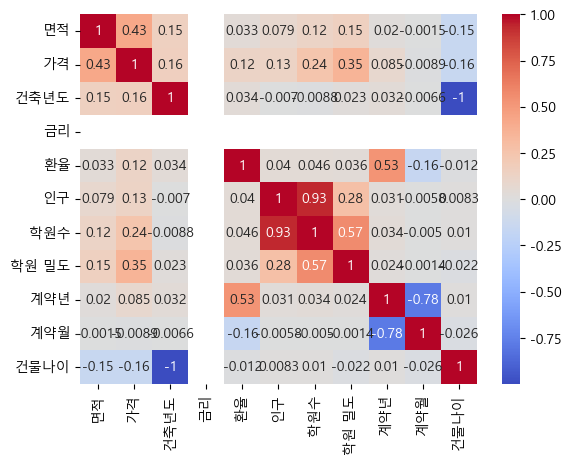

In [62]:
corr_matrix = final_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

In [63]:
final_df.drop(columns=['학원수'], inplace=True)

# 10. XGBoost 드가자